## *Artificial Neutral networks with Back Propogation *


In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [2]:
# defining utility functions

def sigmoid(x):
    '''Sigmoid is used as a activation function after output.'''
    return 1 / (1 + np.exp(-x))


def predict(X, y, w1, w2, verbose=False, bias=True, show_all=False):
    '''Predict the output'''
    y_pred = [] 
    
    # iterating through each input
    for x in X:
        h = sigmoid(x.dot(w1.T))
        if (bias):
            temp_h = np.append(np.ones(1), h)
        else:
            temp_h = h
        o = sigmoid(temp_h.dot(w2.T))
        
        # storing the output of each input
        y_pred.append(o)

    y = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
                
    # for debugging print the labels for all pictures
    if show_all:
        for idx,x in enumerate(X):
            print(f"Predicted => {y_pred[idx]}, Actual => {y[idx]}")
            plt.imshow(x.reshape(28,28))
            plt.show()
    
    # calculate and return accuracy - this is why we had to reconvert back from OH format
    accuracy = np.mean(y_pred==y)
    if (verbose):
        print(f"Accuracy => {accuracy*100}")
    return accuracy

In [3]:
def backprop(X, Y, n_hid, lr = 0.2,w_init=None,w_scale=1,n_iters=1, batch=False,bias=True):
    if bias:
        # append ones col to X
        ones_col = np.ones((X.shape[0],1))
        X = np.concatenate((ones_col,X), axis=1)
    
    # bias_int is integer version of boolean bias
    bias_int = 1 if bias else 0 # add 1 to weigt dimension if bias is needed
    
    # create weights - if no init given, we randomise to v small values
    if w_init is not None:
        w1 = np.ones((n_hid,X.shape[1])) * w_init
        w2 = np.ones((Y.shape[1],n_hid+bias_int)) * w_init
    else:
        w1 = np.random.uniform(size=(n_hid,X.shape[1])) / w_scale
        w2 = np.random.uniform(size=(Y.shape[1],n_hid+bias_int)) / w_scale
            
    # lists to store histories
    history_w1 = [] 
    history_w2 = []
    accuracies = []
    
    # loop over number of iterations
    for i in tqdm(range(n_iters)):
        
        # for each training example 
        for idx, (x,y) in enumerate(zip(X,Y)):
            ### FORWARD PASS
            h = sigmoid(x.dot(w1.T))
            if bias:
                temp_h = np.append(np.ones(1), h) # becuase we dont want to add a bias term to h itself
            else:
                temp_h = h
            o = sigmoid(temp_h.dot(w2.T))
            
            ### BACKWARD PASS
            do = o*(1-o)*(y-o)
            dh = h * (1-h) * do.dot(w2[:,bias_int:]) # skip bias dim if it exists
            
            ### WEIGHT CHANGES
            dw2 = lr * do.reshape(-1,1) * temp_h
            dw1 = lr * dh.reshape(-1,1) *(x) 

            # store deltas if batch update required
            if batch == True:
                history_w1.append(dw1)
                history_w2.append(dw2)
            
            # otherwise stochastic update -> update here
            else:
                ### WEIGHT UPDATES
                w2 += dw2
                w1 += dw1
                
        # for bacth update -> update here
        if batch is True:
            ### WEIGHT UPDATES
            w2 += sum(history_w2)
            w1 += sum(history_w1)

        # Check accuracy while training
        accuracies.append(predict(X,Y,w1,w2,verbose=False,bias=bias))
        
    return w1, w2, accuracies

### 1. Handwritten digit recognition

In [4]:
from tensorflow.keras.datasets import mnist

# loading dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

num_train = 1000
num_test = 100

X_train = X_train[:num_train]
Y_train = Y_train[:num_train]
X_test = X_test[:num_test]
Y_test = Y_test[:num_test]


# Convert y vectors to one hot vectors for our network to work
Y_train_OH = np.zeros((Y_train.size, Y_train.max()+1))
Y_train_OH[np.arange(Y_train.size),Y_train] = 1

Y_test_OH = np.zeros((Y_test.size, Y_test.max()+1))
Y_test_OH[np.arange(Y_test.size),Y_test] = 1

# flatten X and bring into [0,1] range
X_train = X_train.reshape(X_train.shape[0],-1) / 255
X_test = X_test.reshape(X_test.shape[0],-1) / 255

11490434/11490434 [==============================] - 0s 0us/step


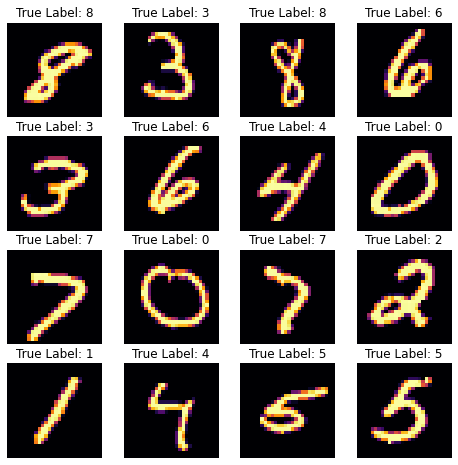

In [5]:
# Visualisation
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    r = np.random.randint(X_train.shape[0])   # get a random image to show
    plt.title('True Label: '+str(Y_train[r])) # show its label as title
    plt.imshow(X_train[r].reshape(28,28), cmap='inferno')    # plot the image
plt.show()

100%|██████████| 500/500 [02:01<00:00,  4.12it/s]


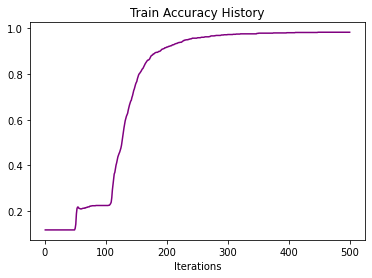

Highest Train accuracy => 0.983
Test Accuracy => 0.85


In [6]:
# Hyperparameters
w_init = None                 # number of hidden units
w_scale = 10                  # value to divide the random w values with
n_hid = 100                   # number of hidden units
lr = 0.01                     # learning rate
n_iters = 500                   # number of iterations / epochs
batch = False                 # if true, algo uses batch update.
bias = False                  # dont add bias dimension

# call backprop function to train
# here our network is 784 (28*28) input units, 100 hidden units, and 10 output units
# the output is in OH format
w1,w2,accuracies = backprop(X_train,Y_train_OH,n_hid,lr,w_init,w_scale,n_iters,batch,bias)

# print highest accuracy and display history
epochs = np.arange(1, len(accuracies)+1)
plt.plot(epochs, accuracies, c='purple')
plt.title('Train Accuracy History')
plt.xlabel('Iterations')
plt.show()
print(f"Highest Train accuracy => {max(accuracies)}")

# check accuracy on seperate test set
test_acc = predict(X_test,Y_test_OH,w1,w2,bias=False,verbose=False,show_all=False)
print(f"Test Accuracy => {test_acc}")

# there is some level of overfitting happening here as seen by 
# the large difference in accuracies